**извлечение признаков из текста на естественном языке**

классификатор текстов HashingVectorizer

_Евгений Борисов <esborisov@sevsu.ru>_

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm.notebook import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [2]:
# import numpy as np
# import pandas as pd
# import re

In [3]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

SKLEARN_VERSION

'1.0.2'

## тексты

In [4]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))
data.sample(5)

записей: 3196


,text,tag
1345,"Объявлены обладатели ""игрового Оскара""\n\n2 декабря 2016 в 9:54\n\nАлександр Михно, 42.TUT.BY\n\nВ Лос-Анджелесе в третий раз прошла ежегодная церемония награждения The Game Awards 2016. На основа...",tech
2496,"На днях в польском Вроцлаве Европейская киноакадемия провела торжественную церемонию награждения, определив ведущий кинопроект 2016 года. Они назвали лучшей лентой фильм «Тони Эрдманн». Это совмес...",culture
3103,СеверИнфо (severinfo.ru) (Вологда) Тундра в ожидании праздника Приближается\nглавный праздник тундры - День Оленя. О подготовке к нему пишет окружная\nгазета ?Няръяна вындер?. Немногие праздники с...,social
1464,Лидер Радикальной партии Олег Ляшко раскритиковал депутата Верховной рады Украины от партии «Батькивщина» Надежду Савченко за встречу с главами самопровозглашенных Донецкой и Луганской народных ре...,politics
3124,"Вестник Приобья (Нягань) Волшебные уроки мастерства В оздоровительном лагере\n?Планета детства?, что действует на базе средней школы ? 4, - необычная\nвстреча. В гости к ребятам пожаловали умельцы...",social


## токенизация и очистка

In [5]:
# собираем словарь из текстов
def get_vocabulary(ds):
    vcb = [ set(s) for s in ds.tolist() ]
    return sorted(set.union(*vcb))

In [6]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

# разрезаем стоки на слова
def tokenize(s): return [ w for w in s.split(' ') if (len(w)>1) ]

In [7]:
data['ctext'] = data['text'].progress_apply(string_normalizer)

  0%|          | 0/3196 [00:00<?, ?it/s]

In [8]:
vcb =  get_vocabulary( data['ctext'].progress_apply( tokenize ) )
print('словарь %i слов'%(len(vcb)))
# pd.DataFrame( vcb ).to_csv('voc.txt',index=False,header=False)

  0%|          | 0/3196 [00:00<?, ?it/s]

словарь 83094 слов


In [9]:
data.sample(5)

,text,tag,ctext
2578,"Луна будет настолько яркой, что «приглушит» видимость метеорного потока Геминиды в 5-10 раз.\n\nВ ночь на 14 декабря произойдет последнее в 2016 году суперлуние. Астрономическое явление смогут наб...",science,луна будет настолько яркой что приглушит видимость метеорного потока геминиды в - раз в ночь на декабря произойдет последнее в году суперлуние астрономическое явление смогут наблюдать и жители ека...
1027,"""Ветер сорвал крышу, а страховку не выплатили"". Что нужно знать о страховании строений\n\n8 декабря 2016 в 11:01\n\nДмитрий Бобков / FINANCE.TUT.BY\n\nОт каких стихийных бедствий можно защитить до...",realty,ветер сорвал крышу а страховку не выплатили что нужно знать о страховании строений декабря в дмитрий бобков finance tut by от каких стихийных бедствий можно защитить дома что нужно знать о страхов...
1824,"Тегеран, , 10:59 — REGNUM Энергетическое сотрудничество России и Ирана как одних из влиятельнейших игроков на нефтяном рынке набирает обороты. В понедельник, 12 декабря, стороны подписали меморанд...",economics,тегеран regnum энергетическое сотрудничество россии и ирана как одних из влиятельнейших игроков на нефтяном рынке набирает обороты в понедельник декабря стороны подписали меморандум о совместной р...
3033,"Руководство одного из читинских ТСЖ, на данный момент уже отстраненное от исполнения должностных обязанностей, должно будет отчитаться за огромный долг перед коммунальщиками и предоставить жильцам...",social,руководство одного из читинских тсж на данный момент уже отстраненное от исполнения должностных обязанностей должно будет отчитаться за огромный долг перед коммунальщиками и предоставить жильцам д...
1872,МИД Японии обнародовал программу визита президента РФ Владимира Путина в Страну восходящего солнца. Об этом сообщает информационное агентство Киодо со ссылкой на внешнеполитическое ведомство.\n\nч...,politics,мид японии обнародовал программу визита президента рф владимира путина в страну восходящего солнца об этом сообщает информационное агентство киодо со ссылкой на внешнеполитическое ведомство читайт...


## Vectorizer

In [10]:
def tokenizer(s): 
    for w in s.split(' '):
        if (len(w)>1): 
            yield w

tf = HashingVectorizer( n_features=4096, norm='l2', tokenizer=tokenizer,token_pattern=None).fit( data['ctext'] )

## формируем датасеты

In [11]:
X = tf.transform( data['ctext'] )
X.shape

(3196, 4096)

In [12]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [13]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

In [14]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2237, 4096), (2237,), (959, 4096), (959,))

## обучаем классификатор

In [15]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(tol=0.19)

## тестируем

In [16]:
o = clf.predict(X_train)
accuracy_score(y_train,o)

0.9995529727313366

In [17]:
o = clf.predict(X_test)
accuracy_score(y_test,o)

0.8342022940563086

In [18]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.90      0.87      0.89        87
           1       0.71      0.89      0.79       101
           2       0.86      0.74      0.79        76
           3       0.90      0.58      0.71        31
           4       0.88      0.93      0.90       123
           5       0.84      0.92      0.88       177
           6       0.72      0.62      0.67        21
           7       0.83      0.59      0.69        17
           8       0.89      0.94      0.91        68
           9       0.54      0.30      0.38        44
          10       0.97      0.97      0.97       118
          11       0.72      0.72      0.72        89
          12       0.75      0.86      0.80         7

    accuracy                           0.83       959
   macro avg       0.81      0.76      0.78       959
weighted avg       0.83      0.83      0.83       959



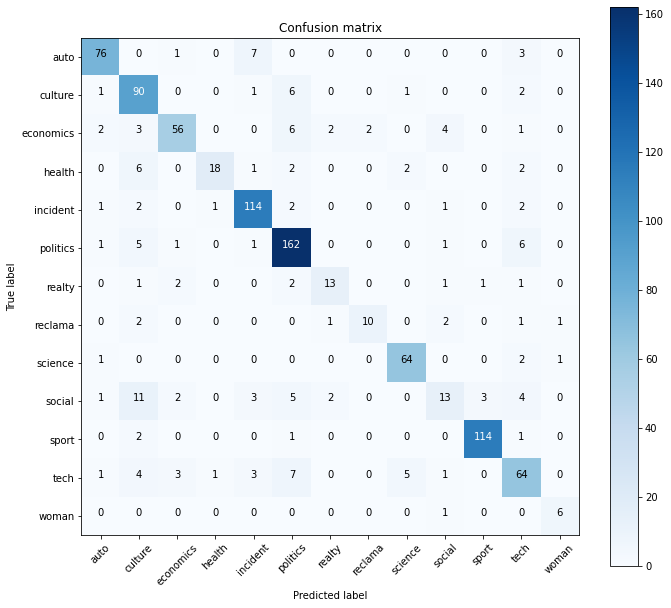

In [19]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [20]:
o = clf.predict(X)

labels_inv = { labels[k]:k for k in labels }

for n in range(10):
    i = rng.randint(len(data))
    print('tag:',data.iloc[i,1])
    print('predict:',labels_inv[o[i]])
    print(re.sub(r'\n\s*\n',' ',data.iloc[i,0][:200])+'...')
    print('- - - - - - - - - - - - - - - - - -')
    

tag: incident
predict: incident
В Минске водитель сбил ребенка, сымитировал разговор по телефону с его мамой и скрылся с места ДТП 7 декабря 2016 в 15:40 AUTO.TUT.BY В Минске неизвестный водитель сбил на переходе ребенка и скрылс...
- - - - - - - - - - - - - - - - - -
tag: auto
predict: auto
Южнокорейский автоконцерн Kia выложил в открытый доступ тизер своего нового спортивного автомобиля – Kia GT. Новинку уже называют самым динамичным автомобилем в линейке «Киа». Судя по видеосюжету, так...
- - - - - - - - - - - - - - - - - -
tag: politics
predict: politics
Она напомнила, что Савченко заявила о формировании своей партии, она не координирует свою деятельность с партией "Батькивщина" и их позиции "кардинально расходятся" Лидер фракции "Батькивщина" Юлия Т...
- - - - - - - - - - - - - - - - - -
tag: sport
predict: sport
МОК продлил санкции в отношении России в связи с допинговыми скандалами 7 декабря 2016 в 20:17 Олег Кошелев, Лозанна, ТАСС Международный олимпийский комитет (МОК) продлил